## Sentiment analysis - Amazon Health and Personal Care Reviews - Part 1
![](https://gitlab.com/sayantan.world98/sentiment-analysis-amazon-health-and-personal-care/-/raw/master/images/img1.jpg)

Sentiment analysis is the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information.

We are using the **Amazon Health and Personal Care Reviews** dataset to perfom Sentiment Analysis. The dataset contains **346,355 reviews**.

Link to the original dataset source: http://jmcauley.ucsd.edu/data/amazon/

Find the project and dataset here: https://gitlab.com/sayantan.world98/sentiment-analysis-amazon-health-and-personal-care

Lets see what is there in our dataset.

Sample data
```
{
  "reviewerID": "A2SUAM1J3GNN3B",
  "asin": "0000013714",
  "reviewerName": "J. McDonald",
  "helpful": [2, 3],
  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",
  "overall": 5.0,
  "summary": "Heavenly Highway Hymns",
  "unixReviewTime": 1252800000,
  "reviewTime": "09 13, 2009"
}
```
Where,

- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review, e.g. 2/3
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)



### Downloading the dataset

In [1]:
!git clone https://gitlab.com/sayantan.world98/sentiment-analysis-amazon-health-and-personal-care.git

Cloning into 'sentiment-analysis-amazon-health-and-personal-care'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.
Checking out files: 100% (4/4), done.


In [3]:
# Loading the dataset in a dataframe
df = pd.read_json('/content/sentiment-analysis-amazon-health-and-personal-care/dataset/Health_and_Personal_Care_5.json', lines=True)

### Importing modules

In [43]:
# DataFrame
import pandas as pd 

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB


#tensorflow
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# Utility
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle

Lets check how many reveiws are there per category (i.e 5 star, 4 star, etc).

In [4]:
df['overall'].value_counts()

5    211633
4     68168
3     33254
2     16754
1     16546
Name: overall, dtype: int64

### Target - Perform Binary Classification

We can see we have a lot of 5 star (positive) reviews compared to the negative ones. Lets consider: 
- 5 and 4 stared reviews as positive class(i.e class - 1).
- 1 and 2 stared reviews as negative class(i.e class - 0). 

In [5]:
# check the number of positive vs. negative tagged sentences, we ignore neutral reviews as of now
positives = df['overall'][(df.overall == 5) | (df.overall == 4)]
negatives = df['overall'][(df.overall == 2) | (df.overall == 1)]

print('Total length of the data is:         {}'.format(df.shape[0]))
print('No. of positve tagged sentences is:  {}'.format(len(positives)))
print('No. of negative tagged sentences is: {}'.format(len(negatives)))

Total length of the data is:         346355
No. of positve tagged sentences is:  279801
No. of negative tagged sentences is: 33300


As we have a biased dataset lets use 32,000 positive reviews and 32,000 negative reviews.

In [7]:
# We use this to give a weight to the helpful reviews and we also applied smoothing.
df['score'] = df.helpful.apply(lambda x: x[0] / (x[1] + 2))
df_pos = df[(df.overall == 5) | (df.overall == 4)]
df_pos = df_pos.sample(n=32000, weights=df.score, random_state=42)
df_neg = df[(df.overall == 2) | (df.overall == 1)]
df_neg = df_neg.sample(n=32000, random_state=42)

Now, lets join the df_pos and df_neg to make our required dataframe.

In [11]:
df_all = pd.concat([df_pos, df_neg])

In [13]:
# Positive class - 1, Negative class - 0
def sentiment_score(n):
  if n == 5 or n == 4:
    return 1
  return 0

df_all['overall']=df_all['overall'].apply(lambda x: sentiment_score(x))

In [14]:
df_all['overall'].value_counts()

1    32000
0    32000
Name: overall, dtype: int64

Remove unwanted Columns (Features) from the dataframe.

In [16]:
df_all = df_all.drop(['reviewerName', 'helpful', 'unixReviewTime', 'reviewTime', 'score', 'summary', 'asin', 'reviewerID'], axis=1)

In [17]:
# Reset index
df_all.reset_index().drop(['index'], axis=1)

,reviewText,overall
0,"My stepdad needed a shower chair, and the ones...",1
1,It works. However it had a lot of bubbles ins...,1
2,We bought these for my 8 year old with high-fu...,1
3,I've owned a front-loader (HE) washing machine...,1
4,"Good value for use in the home; not too big, n...",1
...,...,...
63995,Picked up a pair of Duracell AA batteries on a...,0
63996,This dried up after only one or two sparse use...,0
63997,I had dislocated and broken my shoulder nearly...,0
63998,When I was a child I remember reading a short ...,0


### Data Visualization

Lets take a look how our data frame looks like

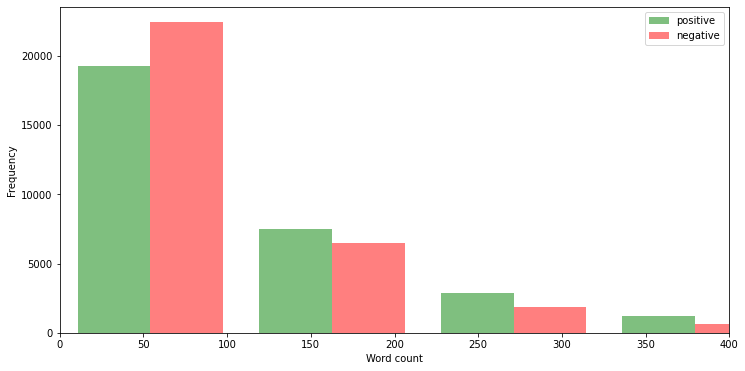

In [48]:
# get a word count per of text
def word_count(words):
    return len(words.split())

# plot word count distribution for both positive and negative

df_all['word count'] = df_all['reviewText'].apply(word_count)
p = df_all['word count'][df_all.overall == 1]
n = df_all['word count'][df_all.overall == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,400)
plt.xlabel('Word count')
plt.ylabel('Frequency')
g = plt.hist([p, n], color=['g','r'], alpha=0.5, label=['positive','negative'], bins=50)
plt.legend(loc='upper right')

In [49]:
df_all = df_all.drop(['word count'], axis=1)

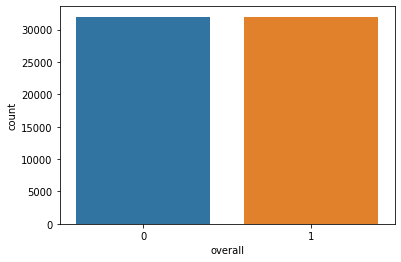

In [51]:
%matplotlib inline
sns.countplot(df_all['overall'])

### Data Processing

In the Text Preprocessing we will do the following:

- Convert the reviews to Lower case.

- Remove punctuations if any.

- We will filter out stopwords. In computing, stop words are words which are filtered out before or after processing of natural language data.

- Perform lemmatization on each word.

In [52]:
nltk.download('stopwords')
stopword = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
wordLemm = WordNetLemmatizer()
def process_reviews(review):
    # Lower Casing
    review = review.lower()
    #Remove punctuations
    review = review.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(review)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopword]
    #reducing a word to its word stem using lemmatization
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)

In [20]:
df_all['reviewText'] = df_all['reviewText'].astype('str')

In [21]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [22]:
df_all['processed_reviews'] = df_all['reviewText'].apply(lambda x: process_reviews(x))
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [42]:
df_all

,reviewText,overall,processed_reviews
114050,"My stepdad needed a shower chair, and the ones...",1,stepdad needed shower chair one local store fa...
329492,It works. However it had a lot of bubbles ins...,1,work however lot bubble inside chipped big jun...
245270,We bought these for my 8 year old with high-fu...,1,bought year old highfunctioning autism easily ...
195288,I've owned a front-loader (HE) washing machine...,1,ive owned frontloader washing machine since 20...
46761,"Good value for use in the home; not too big, n...",1,good value use home big small easily disposed ...
...,...,...,...
179920,Picked up a pair of Duracell AA batteries on a...,0,picked pair duracell aa battery vacation recha...
210206,This dried up after only one or two sparse use...,0,dried one two sparse us hardly enough make sur...
112793,I had dislocated and broken my shoulder nearly...,0,dislocated broken shoulder nearly six month ag...
44474,When I was a child I remember reading a short ...,0,child remember reading short childrens story c...


### Vectorization and Splitting the data

In [25]:
X = df_all['processed_reviews'].values
y = df_all['overall'].values

In [26]:
print(X.shape)
print(y.shape)

(64000,)
(64000,)


#### Convert text to word frequency vectors

**TF-IDF**

This is an acronym than stands for Term Frequency – Inverse Document Frequency which are the components of the resulting scores assigned to each word.

- Term Frequency: This summarizes how often a given word appears within a document.
- Inverse Document Frequency: This downscales words that appear a lot across documents.

In [27]:
#Convert a collection of raw documents to a matrix of TF-IDF features.
vector = TfidfVectorizer(sublinear_tf=True)
X = vector.fit_transform(X)
print(f'Vector fitted.')
print('No. of feature_words: ', len(vector.get_feature_names()))

Vector fitted.
No. of feature_words:  139519


In [28]:
print(X.shape)
print(y.shape)

(64000, 139519)
(64000,)


### Split train and test

The Preprocessed Data is divided into 2 sets of data:

- Training Data: The dataset upon which the model would be trained on. Contains 80% data.
- Test Data: The dataset upon which the model would be tested against. Contains 20% data.

We selected random seed to be 42.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

### Evaluating the Model

In [36]:
def model_Evaluate(model):
    #accuracy of model on training data
    acc_train=model.score(X_train, y_train)
    #accuracy of model on test data
    acc_test=model.score(X_test, y_test)
    
    print('Accuracy of model on training data : {}'.format(acc_train*100))
    print('Accuracy of model on testing data : {} \n'.format(acc_test*100))

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    print(cf_matrix)
    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'YlGn',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Logistic Regression

Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (a form of binary regression).

To read more: https://machinelearningmastery.com/logistic-regression-for-machine-learning/

Accuracy of model on training data : 88.623046875
Accuracy of model on testing data : 84.46875 

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      6460
           1       0.84      0.85      0.84      6340

    accuracy                           0.84     12800
   macro avg       0.84      0.84      0.84     12800
weighted avg       0.84      0.84      0.84     12800

[[5431 1029]
 [ 959 5381]]


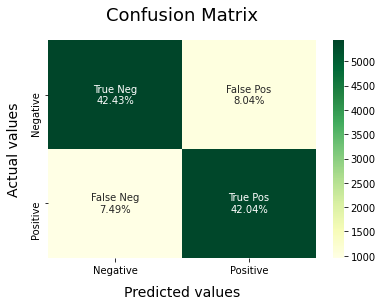

In [37]:
lg = LogisticRegression()
lg.fit(X_train, y_train)
model_Evaluate(lg)

**Observation**

- <font color=green>Performs quite good in detecting the True Positives and True Negatives.
- This Model did not overfit or underfit.</font>
- Can be concluded to be one of the best choice when it comes to binary classification.

### Linear Support Vector Classification.

Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

This class supports both dense and sparse input and the multiclass support is handled according to a one-vs-the-rest scheme.

To read more: https://www.kaggle.com/xingewang/the-math-behind-linear-svc-classifier

Accuracy of model on training data : 95.66796875
Accuracy of model on testing data : 83.9765625 

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      6460
           1       0.84      0.84      0.84      6340

    accuracy                           0.84     12800
   macro avg       0.84      0.84      0.84     12800
weighted avg       0.84      0.84      0.84     12800

[[5444 1016]
 [1035 5305]]


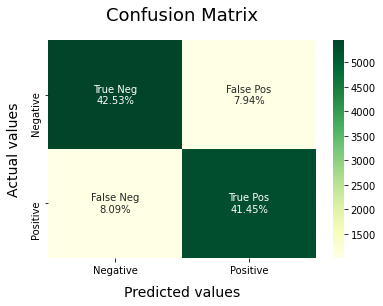

In [38]:
svm = LinearSVC()
svm.fit(X_train, y_train)
model_Evaluate(svm)

**Observation**

- <font color=green>Performs quite good in detecting the True Positives and True Negatives.</font>
- <font color=orange>This Model has a slight tendency to overfit.</font>
- Definitely a true competitor of Logistic Regression.

### Random Forest Classifier.

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

Accuracy of model on training data : 90.6953125
Accuracy of model on testing data : 74.9765625 

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      6460
           1       0.75      0.75      0.75      6340

    accuracy                           0.75     12800
   macro avg       0.75      0.75      0.75     12800
weighted avg       0.75      0.75      0.75     12800

[[4869 1591]
 [1612 4728]]


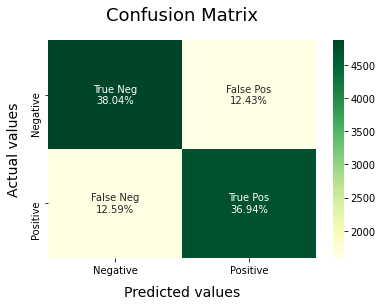

In [39]:
rf = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', max_depth=50)
rf.fit(X_train, y_train)
model_Evaluate(rf)

**Observation**

- <font color=orange>Does not perform too good in detecting the True Positives and True Negatives.</font>
- <font color=red>This Model has a high tendency to overfit.</font>

### Naive Bayes

In statistics, naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naïve) independence assumptions between the features (see Bayes classifier). They are among the simplest Bayesian network models, but coupled with kernel density estimation, they can achieve higher accuracy levels.

Accuracy of model on training data : 71.306640625
Accuracy of model on testing data : 66.546875 

              precision    recall  f1-score   support

           0       0.63      0.83      0.72      6460
           1       0.74      0.49      0.59      6340

    accuracy                           0.67     12800
   macro avg       0.69      0.66      0.65     12800
weighted avg       0.69      0.67      0.66     12800

[[5386 1074]
 [3208 3132]]


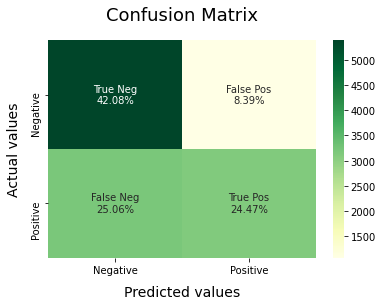

In [40]:
nb = BernoulliNB()
nb.fit(X_train, y_train)
model_Evaluate(nb)

**Observation**

- <font color='green'>This Model does not overfit or underfit.</font>
- <font color='orange'>More biased towards false negatives.</font>
- <font color='red'>Poor performance when compared to other models, but may gain higher accuracy if coupled with kernel density estimation.</font>


### Multinomial Naive Bayes

Naive Bayes classifier for multinomial models

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

Accuracy of model on training data : 87.859375
Accuracy of model on testing data : 80.6484375 

              precision    recall  f1-score   support

           0       0.88      0.72      0.79      6460
           1       0.76      0.90      0.82      6340

    accuracy                           0.81     12800
   macro avg       0.82      0.81      0.81     12800
weighted avg       0.82      0.81      0.80     12800

[[4624 1836]
 [ 641 5699]]


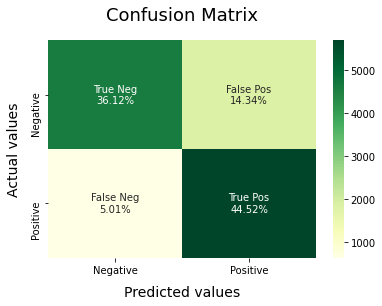

In [41]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)
model_Evaluate(nb)

**Observation**

- <font color='green'>This Model does not overfit or underfit.</font>
- <font color='orange'>Slightly biased towards false positives.</font>
- Overall its a quite good model.


### Model Saving, Loading and Prediction 

In [53]:
import pickle

file = open('vectoriser.pickle','wb')
pickle.dump(vector, file)
file.close()

file = open('logisticRegression.pickle','wb')
pickle.dump(lg, file)
file.close()

file = open('SVM.pickle','wb')
pickle.dump(svm, file)
file.close()

file = open('RandomForest.pickle','wb')
pickle.dump(rf, file)
file.close()

file = open('NaivesBayes.pickle','wb')
pickle.dump(nb, file)
file.close()

**Conclusion**

We can use the Logistic Regression for most cases and it will yeild good results.

### Predict using saved model

In [54]:
def load_models():
    # Load the vectoriser.
    file = open('vectoriser.pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('logisticRegression.pickle', 'rb')
    lg = pickle.load(file)
    file.close()
    return vectoriser, lg

In [55]:
def predict(vectoriser, model, text):
    # Predict the sentiment
    processes_text=[process_reviews(sen) for sen in text]
    textdata = vectoriser.transform(processes_text)
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

Lets see how the model performs when we say something sarcastically.

In [59]:
if __name__=="__main__":
    # Loading the models.
    vectoriser, lg = load_models()
    
    # Text to classify should be in a list.
    text = ["Such an amazing trimmer. It is a must buy for anyone who is thinking to buy a trimmer. It is a multipurpose trimmer which has got 10 modes with custom settings. Completely satisfied with the purchase.",
            "Absolute garbage. Do not buy this, I would give this zero star if possible.",
            "Definitely worth it if you can sell one of your kidney to afford it. The price makes it really unique from all other products."]
    
    df = predict(vectoriser, lg, text)
    print(df.head())

                                                text sentiment
0  Such an amazing trimmer. It is a must buy for ...  Positive
1  Absolute garbage. Do not buy this, I would giv...  Negative
2  Definitely worth it if you can sell one of you...  Positive


**As expected Machines will never understand Sarcasm :P**

If we don't care about sarcastic reviews we can definitely expect Logistic Regression to serve our purpose.

### Future Work

- Training using RNN (Deep Learning).
- Trying to handle sarcastic reviews.
- Trying to resolve overfitting, which we found in some models.
- Trying sentiment analysis on multiple class (for example Positive, Neutral, Negative).